# In this script we will write our images data into TFRecords.

### Import the data

In [1]:
import numpy as np
import tensorflow as tf
import glob, os
from random import shuffle
import matplotlib.pyplot as plt
import cv2

dataset_path = 'dataset/'
image_height, image_width = 128, 128

In [2]:
def folder_image_class(base_dataset_path):
	'''
	Returns a 2-D list of images path and corresponding labels each in a separate list, total num of files and a list containing 
	classes names.
	The images should be segregated into different folders according to its class and the folders should be
	named after its class.
	
	Parameter
	---------
	base_dataset_path : the path of the dataset folder   | string

	'''

	#Recursively iterates through all the images in the folder .
	#As glob function also returns the folder path (which is unnecessary in our case), we omit it by
	#filtering for it using os.path.isdir function.
	image_path_list = [x for x in glob.glob(base_dataset_path + '/**', recursive=True) if not os.path.isdir(x)]

	#Since the images path also contains the name of the folder (which is the name of the class), we slice the string starting
	#from the base dataset path length and split it by '/'. The name of the folder will be in the first index.
	class_list = [x[len(base_dataset_path):].split('/')[0] for x in image_path_list]
# 	class_list = [0 if 'accordion' in x else 1 for x in class_list]

	#Remove duplicates and sort the class names alphabetically in ascending order.
	classes = list(set(class_list))
	classes.sort()

	#Total number of files.
	total_files = len(image_path_list)

	#Create the 2-D list of images and corresponding labels.
	img_label_list = [[x for x in image_path_list], [x for x in class_list]]

	#Shuffle the lists.
	#We have to zip both the list so that the order is maintained.
	combined = list(zip(img_label_list[0], img_label_list[1]))
	shuffle(combined)

	#Retrieve the shuffled list.
	img_label_list[0][:],img_label_list[1][:] = zip(*combined)


	return (img_label_list, total_files, classes)

In [3]:
def read_image(im):
    
    im_ = cv2.imread(im)
    im_ = cv2.resize(im_, (image_height, image_width))
    im_ = cv2.cvtColor(im_, cv2.COLOR_BGR2RGB)
    im_ = im_.astype(np.float32)
    return im_

In [4]:
data_list, total_files_num ,_ = folder_image_class(dataset_path)
#data list is a 2D list. The first dimension of the list contains a list of paths to the images while the 
#second dimension of the list contains a list of labels corresponding to the images.
for x in range(total_files_num):
    print("Image path :  %s, label :  %s"%(str(data_list[0][x]), str(data_list[1][x])))

Image path :  dataset/airplanes/image_0017.jpg, label :  airplanes
Image path :  dataset/airplanes/image_0006.jpg, label :  airplanes
Image path :  dataset/airplanes/image_0076.jpg, label :  airplanes
Image path :  dataset/accordion/image_0032.jpg, label :  accordion
Image path :  dataset/airplanes/image_0054.jpg, label :  airplanes
Image path :  dataset/accordion/image_0009.jpg, label :  accordion
Image path :  dataset/accordion/image_0055.jpg, label :  accordion
Image path :  dataset/accordion/image_0023.jpg, label :  accordion
Image path :  dataset/accordion/image_0043.jpg, label :  accordion
Image path :  dataset/airplanes/image_0046.jpg, label :  airplanes
Image path :  dataset/airplanes/image_0011.jpg, label :  airplanes
Image path :  dataset/airplanes/image_0026.jpg, label :  airplanes
Image path :  dataset/accordion/image_0047.jpg, label :  accordion
Image path :  dataset/accordion/image_0029.jpg, label :  accordion
Image path :  dataset/accordion/image_0044.jpg, label :  accor

### Write into TFRecords

In order to store data into a TFRecords file, the data has to be stored in a protocol buffer called **Example** and serialized to string first. The **Example** protocol buffer contains **Features**. **Features** wraps a _list_ of data of a specific type for Tensorflow's understanding. The _list_ can be of type _bytes_, _float_ or _int64_.

**Helper functions to convert data to features of specific type**

In [5]:
def _int64_feature(value):
    #pass the tf.train.Int64List into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    #pass the tf.train.BytesList into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    #pass the tf.train.Floatlist into tf.train.Feature as the data type. The given value must be in list format.
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

**Write into a TFRecords file**

In [6]:
filename = 'train.tfrecords'

writer = tf.python_io.TFRecordWriter(filename)

test_img = None

for idx in range(total_files_num):
    
    #print progress for every 100 data
    if not idx % 100 :
        
        print('Data : {}/{}'.format(idx, total_files_num))
    
    im = read_image(data_list[0][idx])
    
    test_img = im
    label = data_list[1][idx]
    
    #create the feature
    feature = {
        'train/image': _bytes_feature(tf.compat.as_bytes(im.tostring())),
        'train/label': _bytes_feature(tf.compat.as_bytes(str(label)))
    }
    
    #create the example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    #convert the example into string and write it into TFRecords
    writer.write(example.SerializeToString())

print("Finished !")
writer.close()

Data : 0/121
Data : 100/121
Finished !


### Read from a TFRecords file

To read TFRecords file, first we need to create a list of filenames. The filenames will be held in a FIFO queue. The queue can be used to pass parameters like **num_epochs** to load a limited num of data.

Then a reader and a decoder have to be defined. The decoder takes a serialized Example and a dictionary that maps feature keys to FixedLenFeature or VarLenFeature values.

In [7]:
data_path = 'train.tfrecords'

sess = tf.InteractiveSession()

feature = {
    'train/image': tf.FixedLenFeature([], tf.string),
    'train/label': tf.FixedLenFeature([], tf.string)
}

#FIFO queue
filename_queue = tf.train.string_input_producer([data_path])

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)

#decode the record
features = tf.parse_single_example(serialized_example,features=feature)

#Convert the image data from string back to the number
image = tf.decode_raw(features['train/image'], tf.float32)

#cast label into string
label = tf.cast(features['train/label'], tf.string)

image = tf.reshape(image, [128,128,3])

#read the images in batches
images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)

In [8]:
#local variables have to be set for the queue
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)

#to run the FIFO queue
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

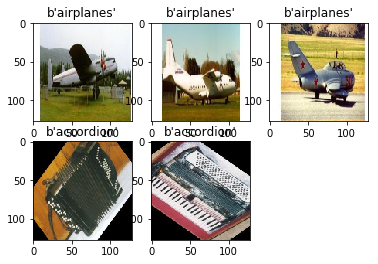

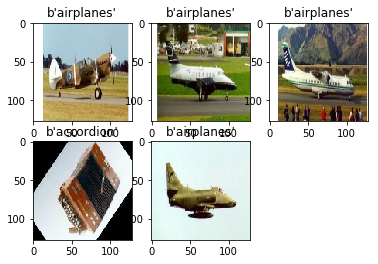

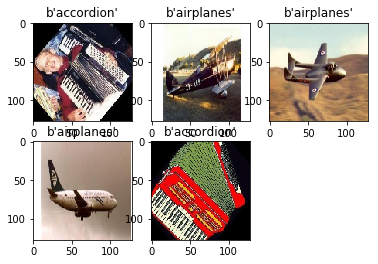

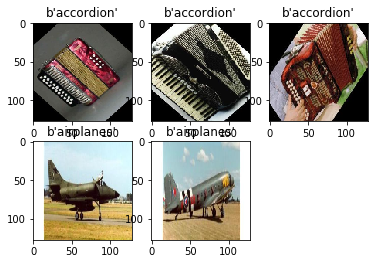

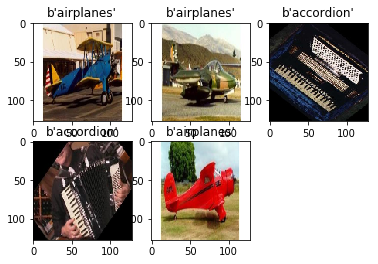

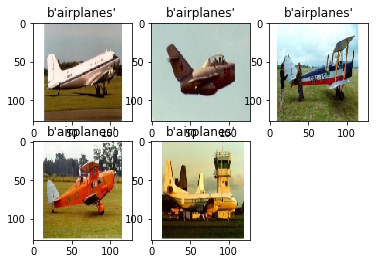

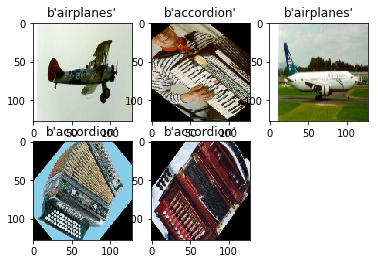

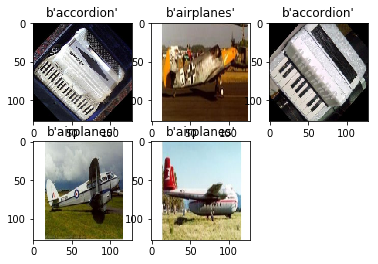

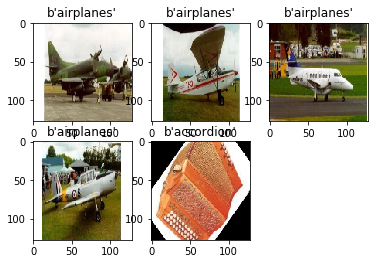

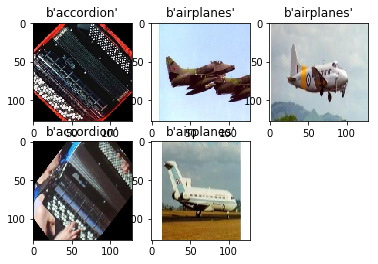

In [9]:
#plot the images back
for idx in range(10):
    img,lbl = sess.run([images, labels])
    img = img.astype(np.uint8) #8 bit unsigned integer. i.e. pixel values
    
    for j in range(5):
        plt.subplot(2,3, j+1)
        plt.imshow(img[j])
        plt.title(lbl[j])
    plt.show()

In [10]:
coord.request_stop()
coord.join(threads)
sess.close()